How parameter selection affects model quality?

In [ ]:
import os
from collections import Counter, defaultdict, OrderedDict
from itertools import combinations
from math import pi
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.metrics import (accuracy_score, classification_report, 
                             f1_score, precision_score, recall_score)
from sklearn.model_selection import (KFold, RandomizedSearchCV, GridSearchCV)
from sklearn.tree import DecisionTreeClassifier


from imblearn.over_sampling import RandomOverSampler

from skopt import BayesSearchCV

from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input


#### Preproccesing

In [108]:
train_dir = Path('./data/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('./data/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path('./data/validation')
val_filepaths = list(val_dir.glob(r'**/*.jpg'))

aug_dir = Path('./data/augmented/')
aug_filepaths = list(aug_dir.glob(r'**/*.jpg')) + list(aug_dir.glob(r'**/*.jpeg'))

data = train_filepaths + test_filepaths + val_filepaths

In [109]:
def paths_to_dataframe(path):
    labels = []
    for i in range(len(path)):
        labels.append(str(path[i]).split(os.sep)[-2])

    labels = pd.Series(labels, name='Label')
    path = pd.Series(path, name='Path').astype(str)

    df = pd.concat([path, labels], axis=1)

    df = df.sample(frac=1).reset_index(drop = True)

    return df
    
data_df = paths_to_dataframe(data)

In [112]:
data_df = data_df.sample(frac=1, random_state=42)
data_df.shape

(3535, 2)

In [113]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

X = np.array(data_df['Path'])
y = np.array(data_df['Label'])

In [114]:
def metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1: ", f1)

    classification_rep = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(classification_rep)

    classes = np.unique(y_test)
    class_accuracy = {}
    for cls in classes:
        indices = np.where(y_test == cls)[0]
        class_accuracy[cls] = accuracy_score(y_test[indices], np.array(y_pred)[indices])

    file_path = './wynik.txt'
    with open(file_path, 'a') as file:
        file.write(str(accuracy))
        file.write('\n')
        file.write(str(precision))
        file.write('\n\n')


    return accuracy, precision, recall, f1, class_accuracy

In [115]:
def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    return features.flatten()

In [116]:
def sort_classes_by_gini_index(X_train, y_train):
    unique_labels = np.unique(y_train)
    gini_indices_per_class = {label: 0 for label in unique_labels}

    tree = DecisionTreeClassifier()
    tree.fit(X_train, y_train)

    feature_importances = tree.feature_importances_
    sorted_features = np.argsort(feature_importances)[::-1]

    for label in unique_labels:
        indices = np.where(y_train == label)[0]
        gini_indices_per_class[label] = np.mean(feature_importances[sorted_features[:len(indices)]]) if len(indices) > 0 else 0

    sorted_labels = sorted(unique_labels, key=lambda label: gini_indices_per_class[label], reverse=True)
    return sorted_labels

#### Nested Dichotomy

In [117]:
def nested_dichotomy(X_train, y_train, X_test, param_grid, method):
    unique_labels = sort_classes_by_gini_index(X_train, y_train)
    classifiers = []
    parameters = []

    for i in unique_labels:
        y_binary = np.where(y_train == i, 1, 0)

        if len(np.unique(y_train)) > 1:
            balancer = RandomOverSampler(random_state=42)
            X_train_balanced, y_train_balanced = balancer.fit_resample(X_train, y_binary)
        else:
            X_train_balanced = X_train
            y_train_balanced = y_binary

        if method == 'GridSearchCV':
            search_method = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        elif method == 'RandomizedSearchCV': 
            search_method = RandomizedSearchCV(DecisionTreeClassifier(), param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
        elif method == 'BayesSearchCV':
            search_method = BayesSearchCV(DecisionTreeClassifier(), param_grid, n_iter=10, cv=5, random_state=42, n_jobs=-1)

        search_method.fit(X_train_balanced, y_train_balanced)
        classifiers.append((search_method, i))
        parameters.append((i, search_method.best_params_))

        print(i)

    predictions = []
    for tree, positive_label in classifiers:
        binary_prediction = tree.best_estimator_.predict(X_test)
        predictions.append(np.where(binary_prediction == 1, positive_label, None))

    results = [None for _ in range(len(X_test))]
    for i in range(len(predictions)):
        for j in range(len(X_test)):
            if predictions[i][j] is not None and results[j] == None:
                results[j] = unique_labels[i]

    for i in range(len(results)):
        if results[i] is None:
            results[i] = unique_labels[0]
        

    return results, predictions, classifiers, parameters

In [ ]:
param_methods = [
'GridSearchCV',
'RandomizedSearchCV',
'BayesSearchCV'
]


def experiment_loop():

    param_grid = {
        'criterion': ['gini', 'entropy', 'log_loss'],
        'splitter': ['best', 'random'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 5, 10],
    }

    scores = [[] for _ in range(k)]
    best_parameters = [[] for _ in range(k)]

    vgg16_model = VGG16(weights='imagenet', include_top=False, pooling='avg')
    X_ext = np.array([extract_features(img_path, vgg16_model) for img_path in X])

    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        X_train, X_val = X_ext[train_index], X_ext[val_index]
        y_train, y_val = y[train_index], y[val_index]

        for method_name in param_methods:
            print(method_name)
            results, pred, models, parameters = nested_dichotomy(X_train, y_train, X_val, param_grid, method_name)
            accuracy, precision, recall, f1, class_accuracy = metrics(y_val, results)
            scores[fold].append((accuracy, precision, recall, f1, class_accuracy, parameters))
            best_parameters[fold].append((method_name,parameters))

    return scores, best_parameters

scores, best_parameters = experiment_loop()

In [ ]:
file_path = './scores3.txt'
with open(file_path, 'a') as file:
    file.write(str(scores))

file_path = './parameters3.txt'
with open(file_path, 'a') as file:
    file.write(str(scores))

In [ ]:
method_params_dict = defaultdict(lambda: defaultdict(list))


for fold_best_parameters in best_parameters:
    for method_name, parameters in fold_best_parameters:
        if isinstance(parameters, list):
            for param in parameters:
                if isinstance(param, tuple):
                    i, param_dict = param
                    for param_name, param_value in param_dict.items():
                        method_params_dict[method_name][param_name].append(param_value)
        elif isinstance(parameters, OrderedDict):
            for param_name, param_value in parameters.items():
                method_params_dict[method_name][param_name].append(param_value)

for method_name, params_values in method_params_dict.items():
    print(f"Method: {method_name}")
    original_param_order = list(params_values.keys())
    for param_name in original_param_order:
        param_values = params_values[param_name]
        counter = Counter(param_values)
        most_common_value, most_common_count = counter.most_common(1)[0]
        print(f"Most common value for parameter '{param_name}': {most_common_value} (appeared {most_common_count} times)")


Method: GridSearchCV
Most common value for parameter 'criterion': entropy (appeared 65 times)
Most common value for parameter 'max_depth': None (appeared 64 times)
Most common value for parameter 'min_samples_leaf': 1 (appeared 126 times)
Most common value for parameter 'min_samples_split': 2 (appeared 49 times)
Most common value for parameter 'splitter': random (appeared 98 times)
Method: RandomizedSearchCV
Most common value for parameter 'splitter': best (appeared 126 times)
Most common value for parameter 'min_samples_split': 10 (appeared 83 times)
Most common value for parameter 'min_samples_leaf': 2 (appeared 118 times)
Most common value for parameter 'max_depth': 30 (appeared 96 times)
Most common value for parameter 'criterion': log_loss (appeared 131 times)
Method: BayesSearchCV
Most common value for parameter 'criterion': entropy (appeared 109 times)
Most common value for parameter 'max_depth': 30 (appeared 178 times)
Most common value for parameter 'min_samples_leaf': 1 (appe

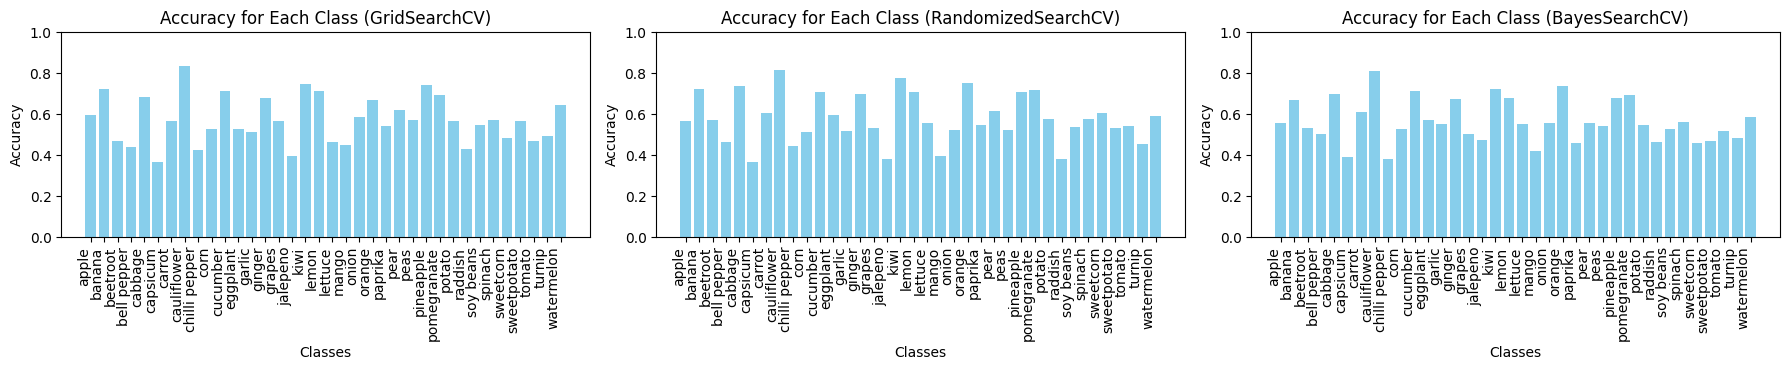

In [ ]:
plt.figure(figsize=(18, 6))

balancer_names = ['GridSearchCV','RandomizedSearchCV','BayesSearchCV']
titles = ['Accuracy for Each Class (GridSearchCV)', 'Accuracy for Each Class (RandomizedSearchCV)', 
          'Accuracy for Each Class (BayesSearchCV)']

class_labels = set()
for i, balancer_name in enumerate(balancer_names, start=1):
    class_accuracy = {}
    for fold_scores in scores:
        for cls, acc in fold_scores[i-1][4].items():
            if cls not in class_accuracy:
                class_accuracy[cls] = []
                class_labels.add(cls)
            class_accuracy[cls].append(acc)

    avg_class_accuracy = {cls: np.mean(acc_list) for cls, acc_list in class_accuracy.items()}
    
    plt.subplot(2, 3, i)
    class_labels_list = sorted(class_labels)
    plt.bar(class_labels_list, [avg_class_accuracy.get(cls, 0) for cls in class_labels_list], color='skyblue')
    plt.title(titles[i-1])
    plt.xlabel('Classes')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=90, ha='right')
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()

In [ ]:
avg_accuracy = []
avg_precision = []
avg_recall = []
avg_f1 = []

for idx, method_name in enumerate(param_methods):

    method_scores = [fold[idx] for fold in scores]

    accuracy = [score[0] for score in method_scores]
    precisions = [score[1] for score in method_scores]
    recalls = [score[2] for score in method_scores]
    f1_scores = [score[3] for score in method_scores]

    avg_accuracy.append(np.mean(accuracy))
    avg_precision.append(np.mean(precisions))
    avg_recall.append(np.mean(recalls))
    avg_f1.append(np.mean(f1_scores))

for idx, method_name in enumerate(param_methods):
    print("Average Accuracy for", method_name + ":", avg_accuracy[idx])
    print("Average Precision for", method_name + ":", avg_precision[idx])
    print("Average Recall for", method_name + ":", avg_recall[idx])
    print("Average F1-Score for", method_name + ":", avg_f1[idx])


Average Accuracy for GridSearchCV: 0.5736916548797737
Average Precision for GridSearchCV: 0.7167654542309632
Average Recall for GridSearchCV: 0.5736916548797737
Average F1-Score for GridSearchCV: 0.6186539572778578
Average Accuracy for RandomizedSearchCV: 0.5816124469589815
Average Precision for RandomizedSearchCV: 0.7247976870934338
Average Recall for RandomizedSearchCV: 0.5816124469589815
Average F1-Score for RandomizedSearchCV: 0.6260620049160182
Average Accuracy for BayesSearchCV: 0.5694483734087695
Average Precision for BayesSearchCV: 0.7152316839695013
Average Recall for BayesSearchCV: 0.5694483734087695
Average F1-Score for BayesSearchCV: 0.6155728377599494


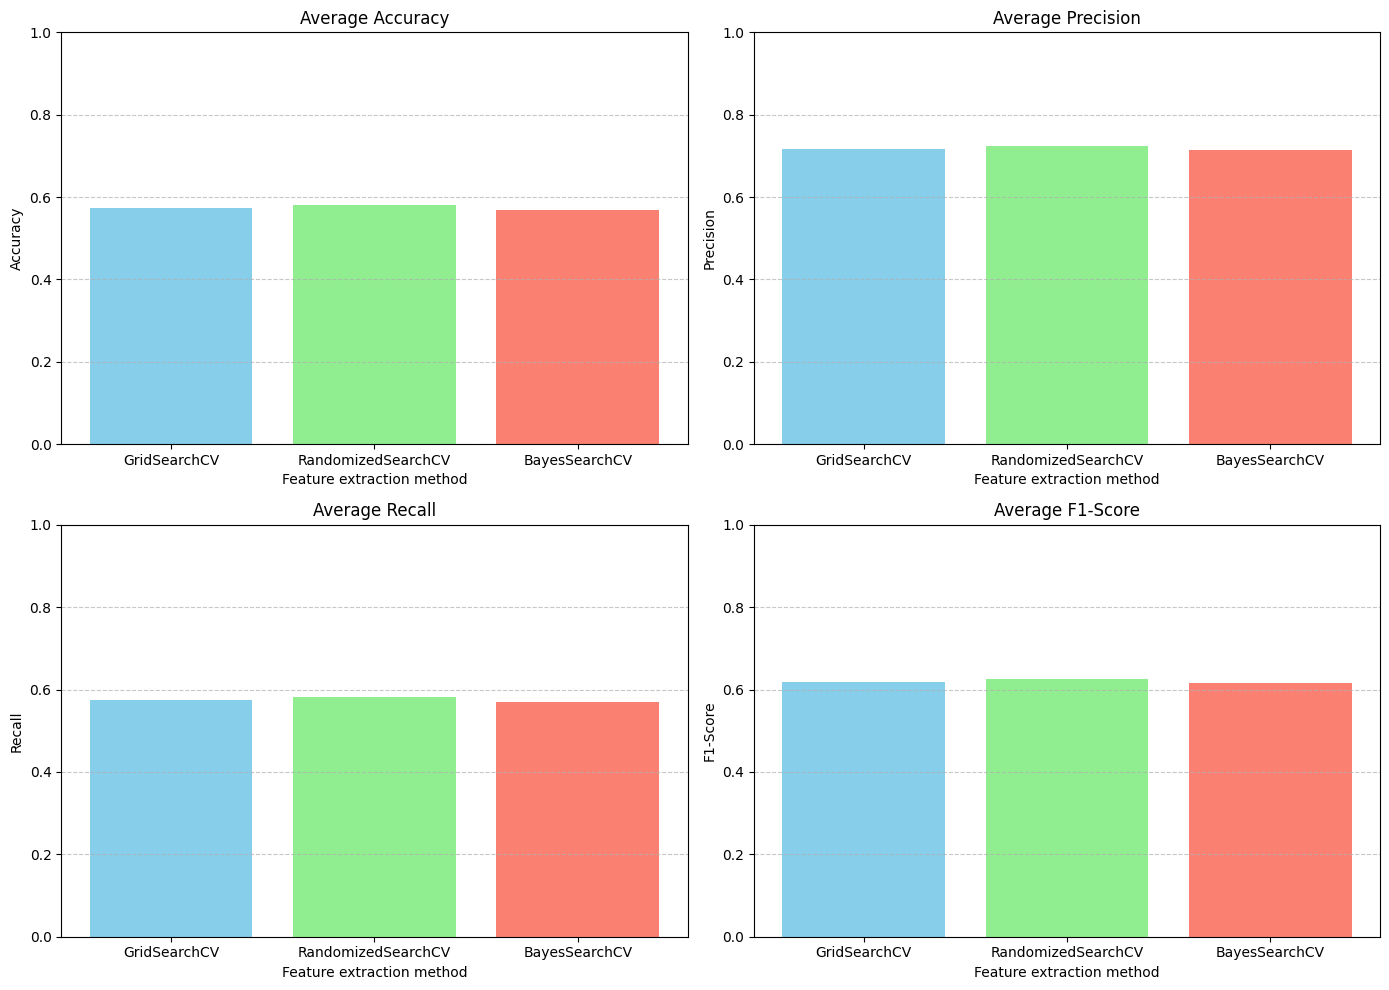

In [ ]:
methods = ['GridSearchCV', 'RandomizedSearchCV', 'BayesSearchCV']
metrics = ['Accuracy','Precision', 'Recall', 'F1-Score']

values = [
    avg_accuracy,
    avg_precision,
    avg_recall,
    avg_f1
]

plt.figure(figsize=(14, 10))
for i in range(len(metrics)):
    plt.subplot(2, 2, i+1)
    plt.bar(methods, values[i], color=['skyblue', 'lightgreen', 'salmon'])
    plt.title('Average ' + metrics[i])
    plt.xlabel('Feature extraction method')
    plt.ylabel(metrics[i])
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
def corrected_t_test(accuracies_1, accuracies_2, corr=0.1):
    """
    Performs the corrected t-test for cross-validation results.

    Parameters:
    accuracies_1 (list or np.array): A list or array of accuracy scores from cross-validation for technique 1.
    accuracies_2 (list or np.array): A list or array of accuracy scores from cross-validation for technique 2.
    corr (float, optional): The correlation between successive folds.

    Returns:
    float: The t-statistic value.
    float: The p-value corresponding to the t-statistic.
    """
    m1 = len(accuracies_1)
    m2 = len(accuracies_2)
    mean_accuracy_1 = np.mean(accuracies_1)
    mean_accuracy_2 = np.mean(accuracies_2)
    variance_1 = np.var(accuracies_1, ddof=1)
    variance_2 = np.var(accuracies_2, ddof=1)
  
    
    corrected_variance_1 = variance_1 / (m1 * (1 - corr))
    corrected_variance_2 = variance_2 / (m2 * (1 - corr))
    standard_error = np.sqrt(corrected_variance_1 / m1 + corrected_variance_2 / m2)
    
    t_statistic = (mean_accuracy_1 - mean_accuracy_2) / standard_error
    p_value = stats.t.sf(np.abs(t_statistic), df=min(m1, m2) - 1) * 2
    
    return t_statistic, p_value



In [126]:
methods = ['GridSearchCV','RandomizedSearchCV','BayesSearchCV']
pairs = combinations(methods, 2)

for pair in pairs:
    method_1, method_2 = pair
    
    accuracies_1 = []
    accuracies_2 = []
    
    method_1_idx = balancer_names.index(method_1)
    method_2_idx = balancer_names.index(method_2)
    
    for fold_scores in scores:
        accuracies_1.append(fold_scores[method_1_idx][0])
        accuracies_2.append(fold_scores[method_2_idx][0])
    
    t_statistic, p_value = corrected_t_test(accuracies_1, accuracies_2)
    
    if t_statistic > 0:
        comparison = f"{method_1} is better than {method_2}"
    elif t_statistic < 0:
        comparison = f"{method_2} is better than {method_1}"
    else:
        comparison = f"There is no significant difference between {method_1} and {method_2}"
    
    significance = "significant" if p_value < 0.05 else "not significant"
    
    print(f'{method_1} vs. {method_2}:')
    print(f'T-statistic: {t_statistic}')
    print(f'P-value: {p_value}')
    print(f'Result: {comparison} (p-value {significance})')


GridSearchCV vs. RandomizedSearchCV:
T-statistic: -1.1077591953049066
P-value: 0.33009032414845874
Result: RandomizedSearchCV is better than GridSearchCV (p-value not significant)
GridSearchCV vs. BayesSearchCV:
T-statistic: 0.6535480694617811
P-value: 0.5490674352704394
Result: GridSearchCV is better than BayesSearchCV (p-value not significant)
RandomizedSearchCV vs. BayesSearchCV:
T-statistic: 1.640287058103837
P-value: 0.1762891501871818
Result: RandomizedSearchCV is better than BayesSearchCV (p-value not significant)


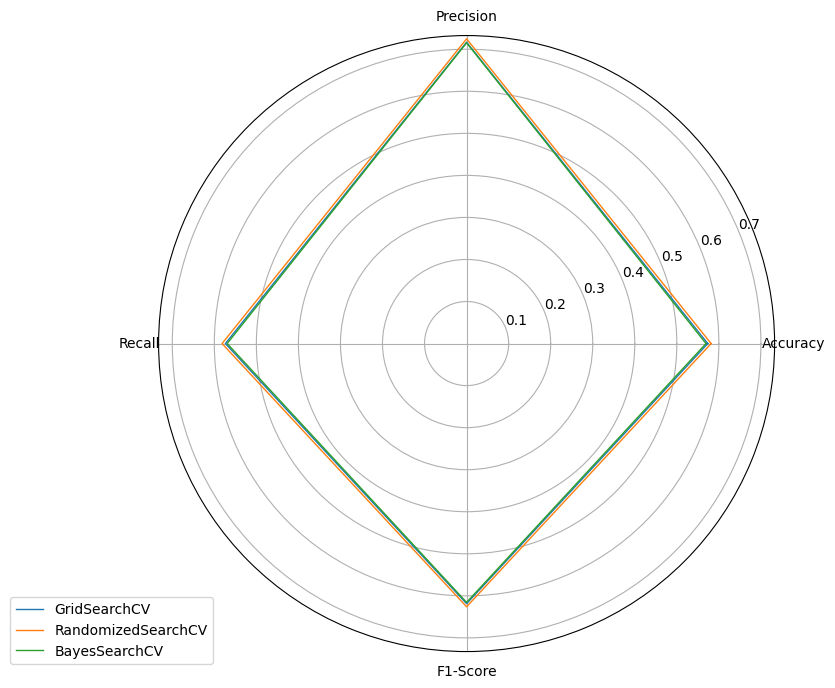

In [ ]:
def plot_radar_chart(methods, avg_accuracy, avg_precision, avg_recall, avg_f1, metrics):
    num_features = 4

    angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for method, avg_acc, avg_prec, avg_rec, avg_f in zip(methods, avg_accuracy, avg_precision, avg_recall, avg_f1):
        values = [avg_acc, avg_prec, avg_rec, avg_f, avg_acc]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=method)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)

    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    plt.show()

plot_radar_chart(methods, avg_accuracy, avg_precision, avg_recall, avg_f1, metrics)